# Проект: классификация

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [157]:
df = pd.read_csv('../data/bank_fin.csv', sep = ';')

In [158]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [159]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [160]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_value_correction(value):
    value = str(value)
    return float(value.replace('$', '').replace(' ', '').replace(',', '.'))

df['balance'] = df.apply(lambda x: balance_value_correction(x['balance']), axis =1)
print(round(df['balance'].mean(), 3))

1529.129


### Задание 4

In [161]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
values = {
    'balance': df['balance'].median()
}

df = df.fillna(values)
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [162]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df.loc[df['job'] == 'unknown', 'job'] = df['job'].mode()[0]
df.loc[df['education'] == 'unknown', 'education'] = df['education'].mode()[0]

In [163]:
mask = (df['job'] == 'management') & (df['education'] == 'secondary')
print(round(df[mask]['balance'].mean(), 4))

1598.883


### Задание 6

In [164]:
# удалите все выбросы для признака balance
# ваш код
def cut_outliers_iqr(df, columns):
    for column in columns:
        quartile_1, quartile_3 = df[column].quantile(0.25), df[column].quantile(0.75)    
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
        mask = mask.apply(lambda x: not x)
        df.drop(index=df[mask].index, inplace=True)
        df.reset_index(inplace=True, drop=True)

        print(f'Нижняя граница: {lower_bound}')
        print(f'Верхняя граница: {upper_bound}')

cut_outliers_iqr(df, ['balance'])

print(f'Количество объектов после очистки: {df.shape[0]}')

Нижняя граница: -2241.0
Верхняя граница: 4063.0
Количество объектов после очистки: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

,deposit,size
0,no,5424
1,yes,4681


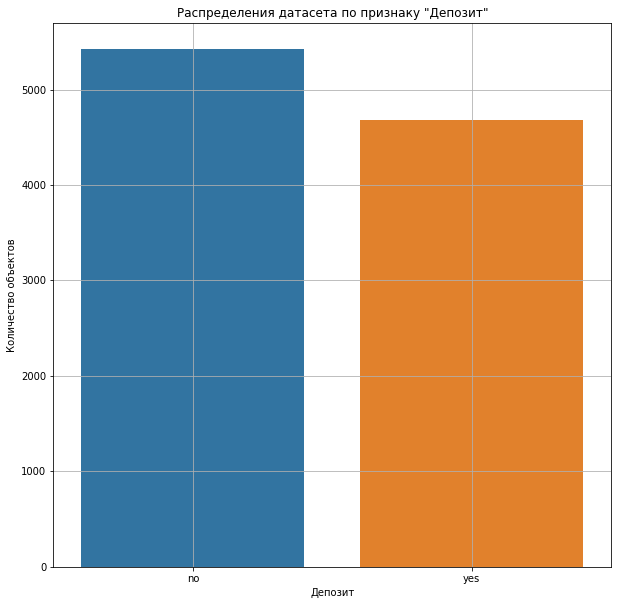

In [165]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df['deposit'].value_counts(normalize=True)

fig_data = df.groupby(['deposit'], as_index=False).size()

display(fig_data)
fig = plt.figure(figsize=(10, 10))
barplot = sns.barplot(
    data=fig_data,
    y='size',
    x='deposit',
    orient='v'
)
barplot.set_title('Распределения датасета по признаку "Депозит"');
barplot.set_xlabel('Депозит');
barplot.set_ylabel('Количество объектов');
barplot.grid()

Данные сбалансированы по целевому признаку

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


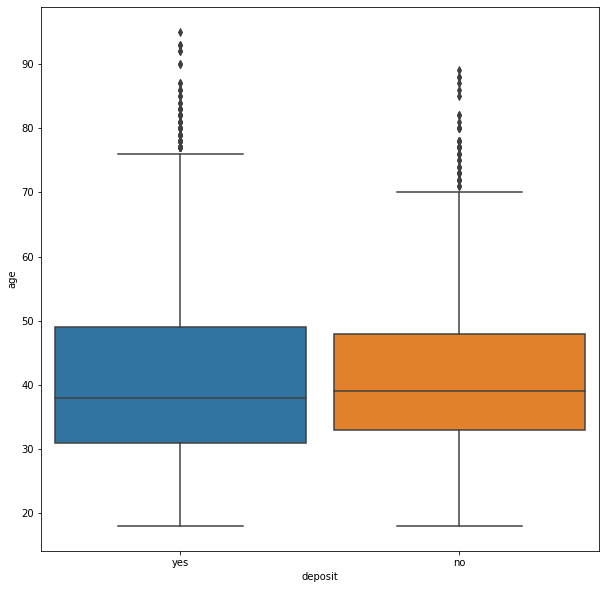

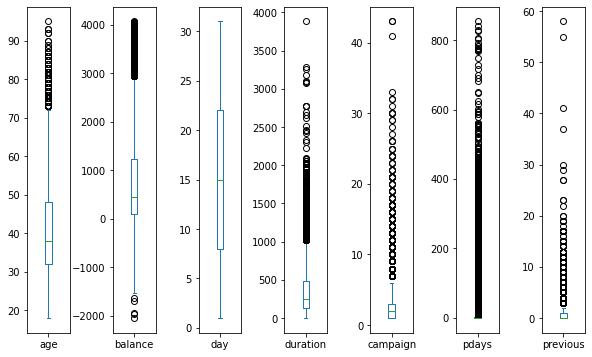

In [166]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
display(df.describe())

#Вариант 1
fig02 = plt.figure(figsize=(10, 10))
boxplot = sns.boxplot(
    data=df,
    y='age',
    x='deposit',
    orient='v',
    width=0.9
)

#Вариант 2
df.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(10, 6)
)
plt.subplots_adjust(wspace=1) 
plt.show()

### Задания 4 и 5

In [167]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

In [168]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df_poutome = df[df['deposit'] == 'yes'].groupby(['poutcome'], as_index=False).size().rename({'size': 'deposit_yes'}, axis=1)
df_poutome['deposit_total'] = df.groupby(['poutcome'], as_index=False).size()['size']
df_poutome['deposit_yes_percent'] = df_poutome['deposit_yes'] / df_poutome['deposit_total'] * 100
df_poutome.sort_values(by='deposit_yes_percent', ascending=False)

,poutcome,deposit_yes,deposit_total,deposit_yes_percent
2,success,861,945,91.111111
1,other,265,481,55.093555
0,failure,547,1109,49.323715
3,unknown,3008,7570,39.735799


### Задание 7

In [169]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df[df['deposit'] == 'no']['month'].value_counts()

may    1776
jul     836
aug     775
jun     606
nov     456
feb     323
apr     317
jan     194
oct      62
sep      46
mar      24
dec       9
Name: month, dtype: int64

### Задание 8

In [170]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_range(age):
    if age < 30: range = 1
    elif 30 <= age < 40: range = 2
    elif 40 <= age < 50: range = 3
    elif 50 <= age < 60: range = 4
    elif age >= 60: range = 5
    return range

df['age_range'] = df['age'].apply(age_range)

In [171]:
df_age = df.groupby('age_range', as_index=False).size()
df_age['deposit_yes'] = df[df['deposit'] == 'yes'].groupby('age_range', as_index=False).size()['size']
df_age['deposit_yes_percent'] = df_age['deposit_yes'] / df_age['size'] * 100

df_age.sort_values(by='deposit_yes_percent', ascending=False)

,age_range,size,deposit_yes,deposit_yes_percent
4,5,653,496,75.957121
0,1,1455,861,59.175258
1,2,3961,1716,43.322393
3,4,1654,670,40.507860
2,3,2382,938,39.378673


### Задания 9 и 10

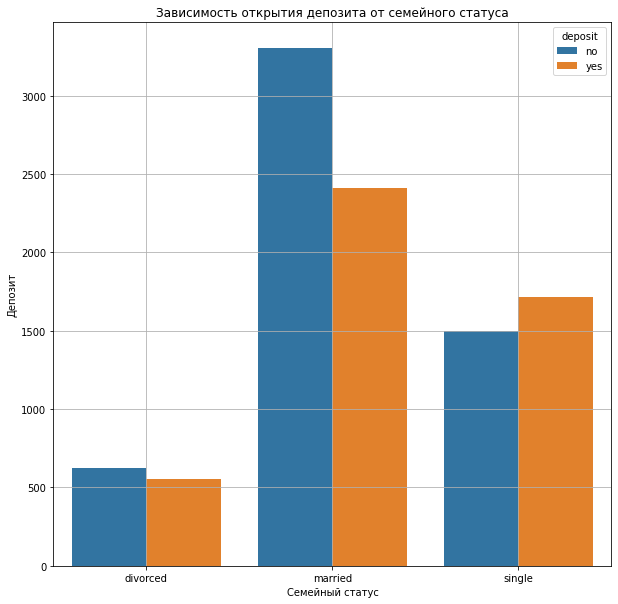

In [172]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig03_data = df.groupby(['deposit', 'marital'], as_index=False)[['deposit', 'marital']].size()

fig03 = plt.figure(figsize=(10, 10))
barplot03 = sns.barplot(
    data=fig03_data,
    y='size',
    x='marital',
    hue='deposit',
    orient='v'
)
barplot03.set_title('Зависимость открытия депозита от семейного статуса');
barplot03.set_xlabel('Семейный статус');
barplot03.set_ylabel('Депозит');
barplot03.grid()

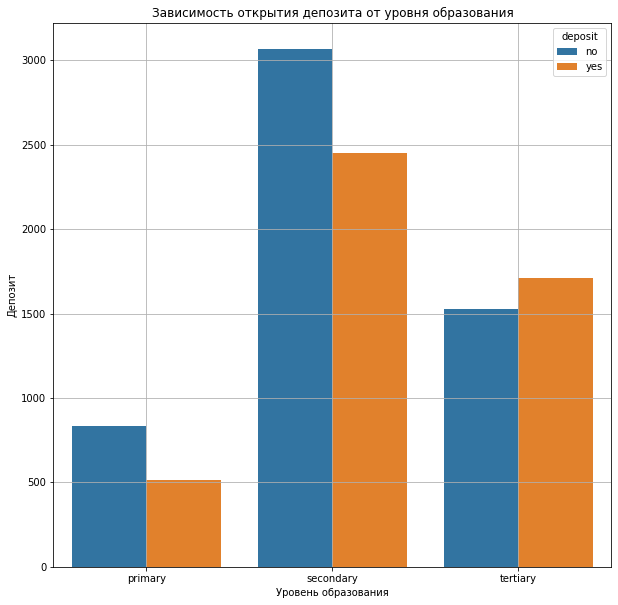

In [173]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig04_data = df.groupby(['deposit', 'education'], as_index=False)[['deposit', 'education']].size()

fig04 = plt.figure(figsize=(10, 10))
barplot04 = sns.barplot(
    data=fig04_data,
    y='size',
    x='education',
    hue='deposit',
    orient='v'
)
barplot04.set_title('Зависимость открытия депозита от уровня образования');
barplot04.set_xlabel('Уровень образования');
barplot04.set_ylabel('Депозит');
barplot04.grid()

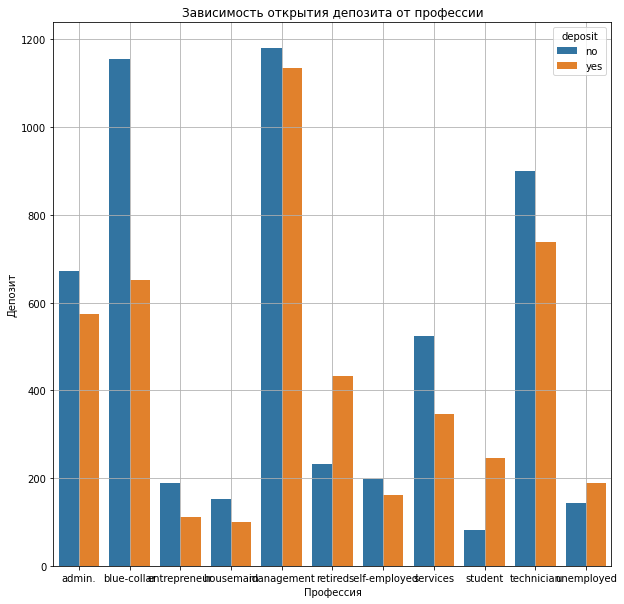

In [174]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig05_data = df.groupby(['deposit', 'job'], as_index=False)[['deposit', 'job']].size()

fig05 = plt.figure(figsize=(10, 10))
barplot05 = sns.barplot(
    data=fig05_data,
    y='size',
    x='job',
    hue='deposit',
    orient='v'
)
barplot05.set_title('Зависимость открытия депозита от профессии');
barplot05.set_xlabel('Профессия');
barplot05.set_ylabel('Депозит');
barplot05.grid()

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


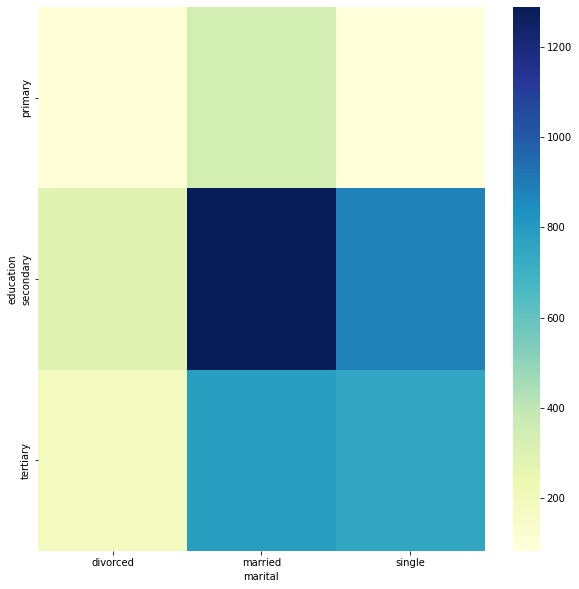

In [175]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_pivot = df[df['deposit'] == 'yes'].pivot_table(index='education', columns='marital', values='age', aggfunc='count')
display(df_pivot)

fig06 = plt.figure(figsize=(10, 10))
heatmap06 = sns.heatmap(data=df_pivot, cmap='YlGnBu')

## Часть 3: преобразование данных

### Задание 1

In [176]:
# преобразуйте уровни образования
def encode_lb(df, col):
    encoder_label = LabelEncoder()
    df_lb = encoder_label.fit_transform(df[col])
    df_lb = pd.DataFrame(df_lb, columns=[col])

    df.drop(columns=[col], inplace=True)
    df = df.join(df_lb, how='left')
    return(df)

df = encode_lb(df, 'education')
print(df['education'].sum())

11995


In [177]:
#преобразование диапазонов возрастов
df = encode_lb(df, 'age_range')
df.describe()

,age,balance,day,duration,campaign,pdays,previous,education,age_range
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230,1.187036,1.612964
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795,0.647373,1.113746
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,1.000000,1.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,1.000000,1.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000,2.000000,2.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,2.000000,4.000000


### Задания 2 и 3

In [178]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
print(round(df['deposit'].std(), 3))

0.499


In [179]:
cols_to_bin = ['default', 'housing', 'loan']
def encode_yn_to_bin(df, cols):
    sum = 0
    for col in cols:
        df[col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)
        sum += df[col].mean()
    display(round(sum, 3))
    return df

df = encode_yn_to_bin(df, cols_to_bin)

0.635

### Задание 4

In [180]:
# создайте дамми-переменные
cols_to_dummy = ['job', 'marital', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=cols_to_dummy)

display(df.shape[1] + 5 - 1)

50

### Задания 5 и 6

<AxesSubplot:>

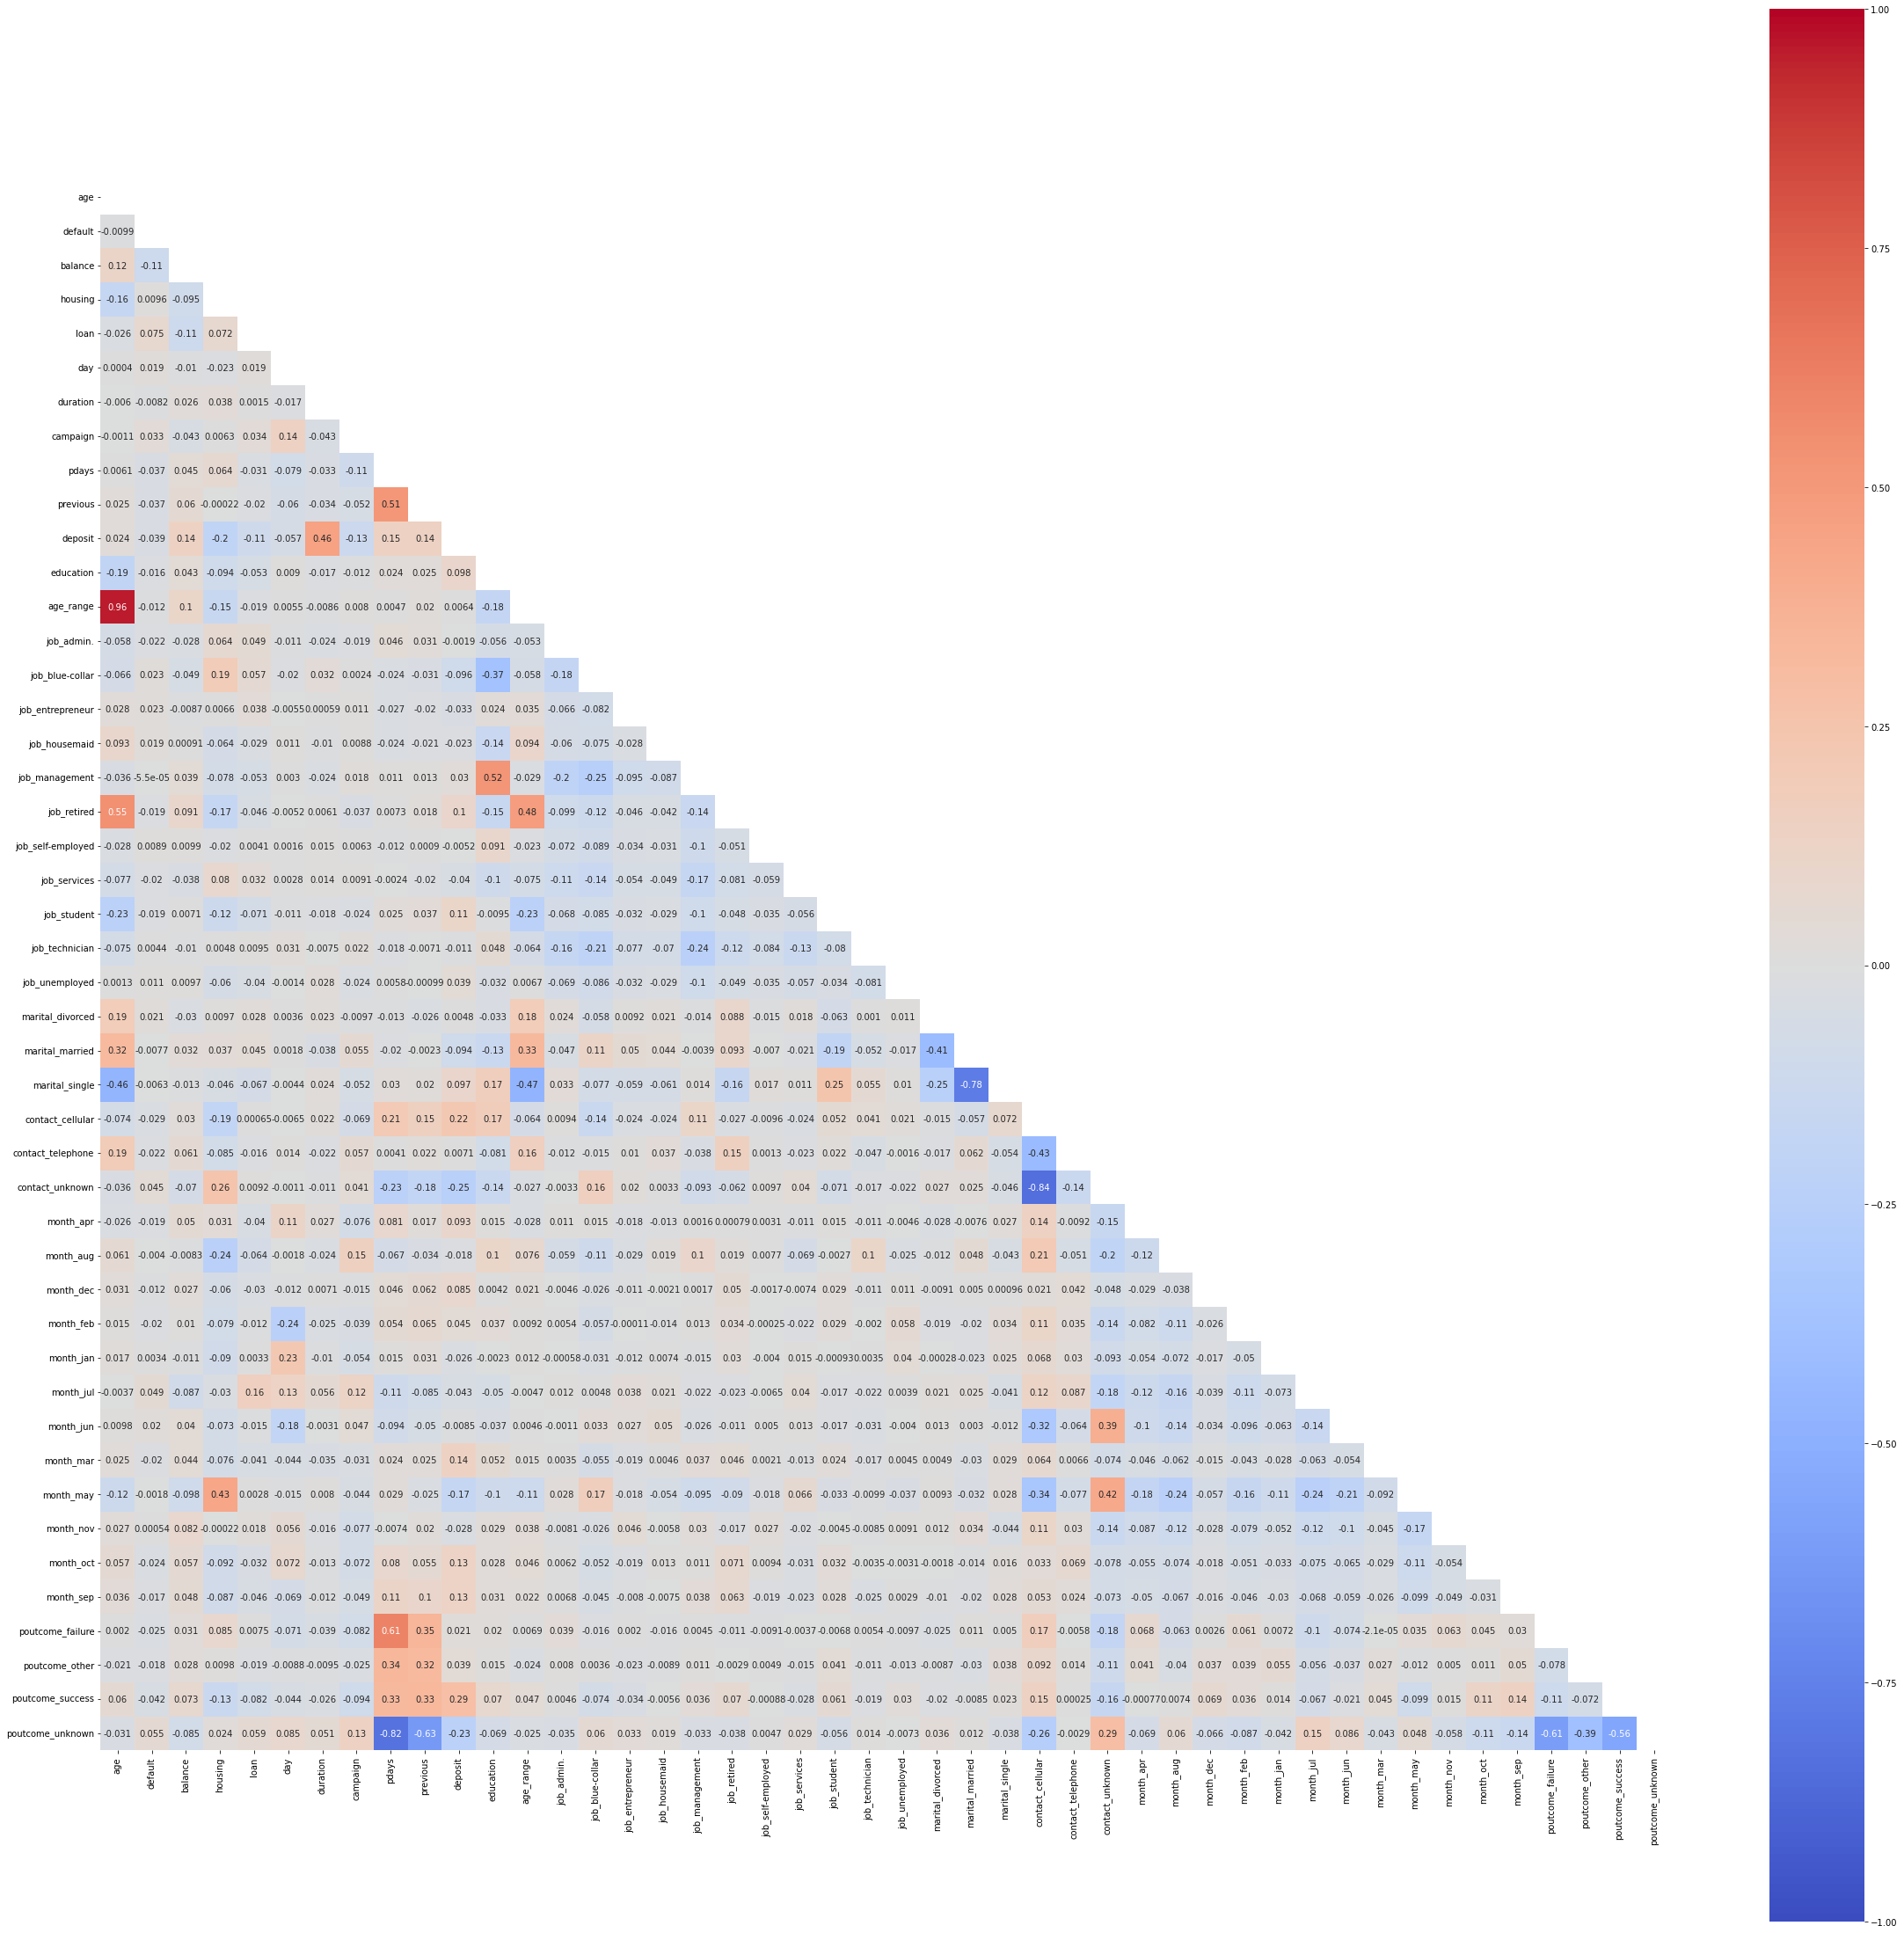

In [181]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

plt.rcParams['figure.figsize'] = (40,40)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, mask=np.triu(corr_matrix), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square=True)

### Задания 7 и 8

In [182]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [183]:
# рассчитайте необходимые показатели
print(f'Размер тестовой выборки {X_test.shape[0]}')
print(f'Стреднее значение целевой переменной {round(y_test.mean(), 2)}')


Размер тестовой выборки 3335
Стреднее значение целевой переменной 0.46


### Задание 9

In [184]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector_kb = SelectKBest(score_func=f_classif, k=15)

selector_kb.fit(X_train, y_train)
selector_kb.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [185]:
cols_to_norm = selector_kb.get_feature_names_out().tolist()
cols_to_norm

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [186]:
# нормализуйте данные с помощью minmaxsxaler

scaler_minmax = preprocessing.MinMaxScaler()
cols_to_norm = selector_kb.get_feature_names_out().tolist()
scaler_minmax.fit(X_train[cols_to_norm])
X_train_norm = pd.DataFrame(scaler_minmax.transform(X_train[cols_to_norm]), columns=cols_to_norm)
X_test_norm = pd.DataFrame(scaler_minmax.transform(X_test[cols_to_norm]), columns=cols_to_norm)

display(round(X_test_norm.iloc[:,0].mean(), 2))

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [187]:
# обучите логистическую регрессию и рассчитайте метрики качества
model_lg = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
model_lg.fit(X_train_norm, y_train)
y_test_pred = model_lg.predict(X_test_norm)

print(f'Метрики для тестовой выборки:\n {metrics.classification_report(y_test, y_test_pred)}') #Платформа принимает ответ 0.81. Небольшие расхождения допусимы из-за разных версий библиотек.

Метрики для тестовой выборки:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [188]:
# обучите решающие деревья, настройте максимальную глубину
model_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7)
model_tree.fit(X_train_norm, y_train)
y_train_pred = model_tree.predict(X_train_norm)
y_test_pred = model_tree.predict(X_test_norm)

print(f'Метрики для обучающей выборки: {metrics.accuracy_score(y_train, y_train_pred)}')
print(f'Метрики для тестовой выборки: {metrics.accuracy_score(y_test, y_test_pred)}')

Метрики для обучающей выборки: 0.8231905465288035
Метрики для тестовой выборки: 0.8044977511244378


### Задание 5

In [189]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': [3, 5, 7],
     'min_samples_split': [2, 5, 7, 10]}
]
searcher_grid = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid,
    n_jobs=-1,
    scoring='f1'
)

searcher_grid.fit(X_train_norm, y_train)
print("Наилучшие значения параметров: {}".format(searcher_grid.best_params_))
print("f1 на тестовой выборке: {}".format(searcher_grid.score(X_test_norm, y_test))) #Платформа принимает ответ 0.79. Небольшие расхождения допусимы из-за разных версий библиотек.

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 10}
f1 на тестовой выборке: 0.7836761778367618


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [191]:
# обучите на ваших данных случайный лес
model_forest = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

model_forest.fit(X_train_norm, y_train)

y_test_pred = model_forest.predict(X_test_norm)
print(f'Метрики для тестовой выборки:\n {metrics.classification_report(y_test, y_test_pred)}')

Метрики для тестовой выборки:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [195]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
dt = tree.DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

model_gb = ensemble.GradientBoostingClassifier(
    max_depth=5,
    n_estimators = 300,
    min_samples_leaf=5,
    learning_rate=0.05,
    random_state=42
)

model_gb.fit(X_train_norm, y_train)
y_test_pred = model_gb.predict(X_test_norm)
print(f'Метрики для тестовой выборки:\n {metrics.classification_report(y_test, y_test_pred)}')

Метрики для тестовой выборки:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 4

In [199]:
# объедините уже известные вам алгоритмы с помощью стекинга
estimators_set01 = [
    ('model_tree', model_tree),
    ('model_lg', model_lg),
    ('model_gb', model_gb)
]

model_staking = ensemble.StackingClassifier(
    estimators=estimators_set01,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

model_staking.fit(X_train_norm, y_train)
y_test_pred = model_staking.predict(X_test_norm)
print(f'Метрики для тестовой выборки:\n {metrics.classification_report(y_test, y_test_pred)}')

Метрики для тестовой выборки:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [200]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

#X_train_norm

selector_kb02 = SelectKBest(score_func=f_classif, k=3)

selector_kb02.fit(X_train_norm, y_train)
selector_kb02.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

In [209]:
from sklearn.feature_selection import RFE
 
selector_rfe = RFE(estimator=model_gb, n_features_to_select=15, step=1)
selector_rfe.fit(X_train_norm, y_train)
 
selector_rfe.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задания 6,7,8

In [211]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna as ot
from sklearn.model_selection import cross_val_score

def score_optuna_rfc(trial):
      space = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200, 1),
        'max_depth': trial.suggest_int('max_depth', 10, 30, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1)
        }

      model = ensemble.RandomForestClassifier(**space, random_state=42)
      model.fit(X_train_norm, y_train)
      
      #Применяем кросс-валидацию при оценке качества модели
      score = cross_val_score(model, X_train_norm, y_train, cv=5, scoring='f1').mean()
      
      return score

study01 = ot.create_study(study_name="RandomForestClassifier", direction="maximize")
study01.optimize(score_optuna_rfc, n_trials=30)
model_forest02 = ensemble.RandomForestClassifier(**study01.best_params, random_state=42)
model_forest02.fit(X_train_norm, y_train)

y_test_pred = model_forest02.predict(X_test_norm)
print(f'Метрики для тестовой выборки:\n {metrics.classification_report(y_test, y_test_pred)}')

[I 2023-03-17 21:02:29,772] A new study created in memory with name: RandomForestClassifier
[I 2023-03-17 21:02:37,198] Trial 0 finished with value: 0.8171576106695115 and parameters: {'n_estimators': 196, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8171576106695115.
[I 2023-03-17 21:02:41,184] Trial 1 finished with value: 0.8192594841406773 and parameters: {'n_estimators': 152, 'max_depth': 23, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8192594841406773.
[I 2023-03-17 21:02:45,912] Trial 2 finished with value: 0.8163663158834152 and parameters: {'n_estimators': 169, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8192594841406773.
[I 2023-03-17 21:02:50,635] Trial 3 finished with value: 0.8217846077775895 and parameters: {'n_estimators': 155, 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8217846077775895.
[I 2023-03-17 21:02:54,466] Trial 4 finished with value: 0.8166424340853953 and parameters: {'n

Метрики для тестовой выборки:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335

